In this notebook we will use OCR (object character recognition) to detect the text from the pages identified in the last notebook. After that we can process the data so we can compare to the already transcribed copy over at Project Gutenberg.

In [6]:
import os
import glob
import cv2
import utils


In [7]:
images=[]
for image in glob.glob("pages/**.png"):
    images.append(cv2.imread(image))

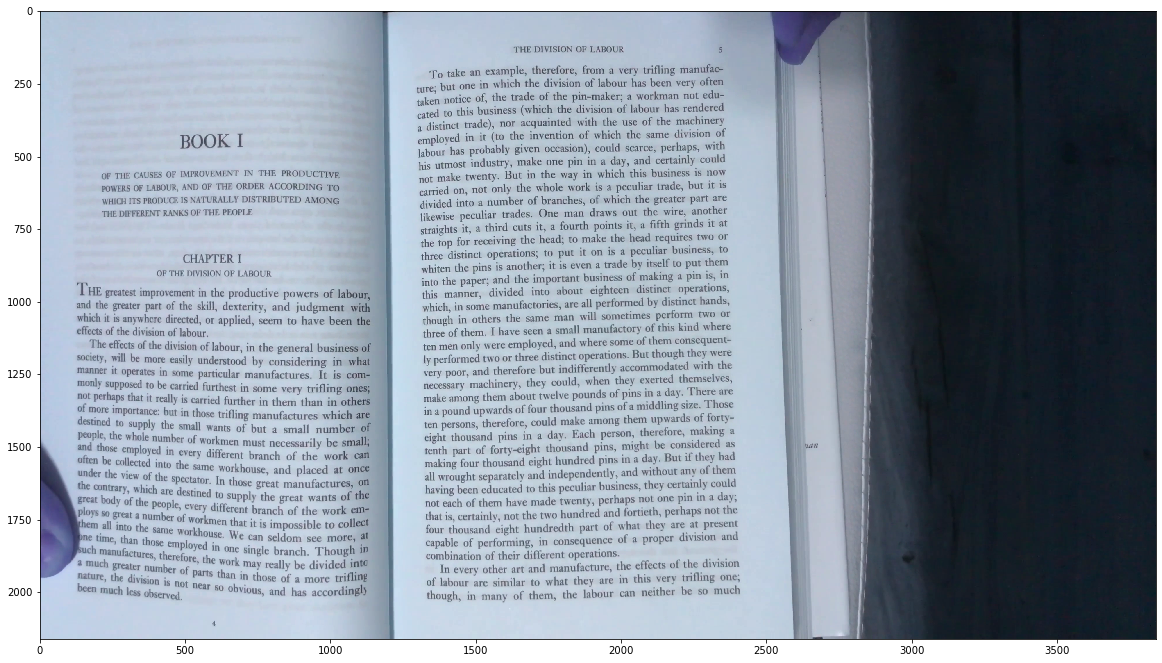

In [8]:
utils.draw_frame(images[0])

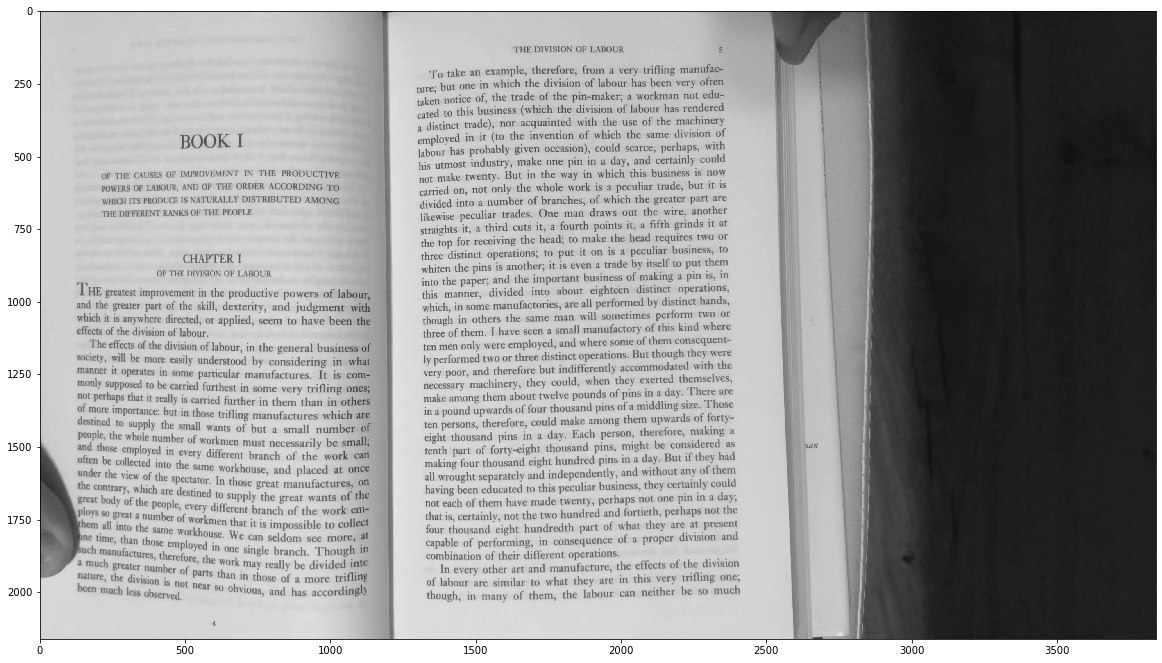

In [9]:
#We don't need color so let's make the images grayscale. Should be 3x faster since no RGB

gray_images=[cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) for frame in images]
utils.draw_frame(gray_images[0])

Most people would start with tesseract. It's free and developed on books. In my experience tesseract isn't very good and you're much better off just paying for AWS Textract or Microsoft Read. It's a fraction of a penny per page and well worth it to get quality results. Longer term I would love to create a great open source OCR model so people can do OCR without needing a credit card/Cloud account somewhere.    
    
In this tutorial I will be using AWS Textract. Follow install steps here https://docs.aws.amazon.com/textract/latest/dg/setup-awscli-sdk.html  


In [10]:
from secret_services import *
#https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/textract.html?highlight=textract

In [11]:
import io
image=gray_images[0]

image_bytes=cv2.imencode(".png", image)[1].tobytes()
image_bytes[:4]

b'\x89PNG'

In [12]:
response=textract.detect_document_text(
    Document={"Bytes":image_bytes}
    
)

In [13]:
from trp import Document
doc = Document(response)

In [18]:
if len(doc.pages)!=1:
    raise Exception("Multiple pages somehow?")
page_lines=[line for page in doc.pages for line in page.lines ]
print([x.text for x in page_lines])

['THE DIVISION OF LABOUR', 'To take an example, therefore, from a very trifling manufac-', 'ture; but one in which the division of labour has been very often', 'taken notice of, the trade of the pin-maker; a workman not edu-', 'cated to this business (which the division of labour has rendered', 'BOOK I', 'a distinct trade), nor acquainted with the use of the machinery', 'employed in it (to the invention of which the same division of', 'labour has probably given occasion), could scarce, perhaps, with', 'OF THE CAUSES OF IMPROVEMENT IN THE PRODUCTIVE', 'his utmost industry, make one pin in a day, and certainly could', 'POWERS OF LABOUR, AND OF THE ORDER ACCORDING TO', 'divided carried make into number only But the of in whole the peculiar business trade, is now is', 'not twenty. way in which this', 'WHICH ITS PRODUCE IS NATURALLY DISTRIBUTED AMONG', 'on, not work is a but it', 'THE DIFFERENT RANKS OF THE PEOPLE', 'a branches, of which the greater part are', 'likewise peculiar trades. One

(array([28.,  3.,  0.,  1., 36.,  6.,  1.,  0.,  0.,  1.]),
 array([0.03187403, 0.09716331, 0.16245259, 0.22774187, 0.29303115,
        0.35832043, 0.42360971, 0.48889899, 0.55418827, 0.61947755,
        0.68476683]),
 <BarContainer object of 10 artists>)

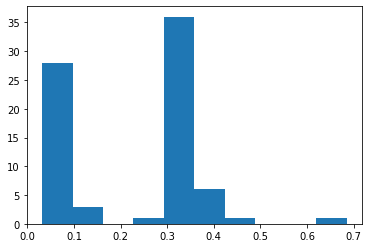

In [19]:
#Our book has 2 pages so let's find the split points
import matplotlib.pyplot as plt 
import numpy as np
left_distances=[line.geometry.boundingBox.left for line in page_lines]
plt.hist(left_distances)

In [20]:
#We'll first get layout by selecting consecutive regions in a histogram
frequencies, cutoff_points=np.histogram(left_distances, bins=6)#6 bins roughly divides each page into 3rds
frequencies

array([31,  0, 37,  7,  0,  1], dtype=int64)

In [21]:
start_stops=[]
start=None
for i,(f1,f2) in enumerate(zip(frequencies,frequencies[1:])):
    if f1>0 and not start:
        start=i
        stop=i
    if f2>0:
        stop=i+1
    if f2<=0:
        start_stops.append((start,stop))
        start=None
    if i==len(frequencies)-2:
        if not start and frequencies[-1]:
            start_stops.append((i+1,i+1))
start_stops

[(0, 0), (2, 3), (5, 5)]

In [22]:
from collections import defaultdict,OrderedDict

grouped_lines=defaultdict(list)
for line in sorted(page_lines, key=lambda x: x.geometry.boundingBox.top):
    for i, (start, stop) in enumerate(start_stops):
        if line.geometry.boundingBox.left>=cutoff_points[start] and line.geometry.boundingBox.left<=cutoff_points[stop+1]:
            grouped_lines[i].append(line)
            break
grouped_lines

defaultdict(list,
            {1: [<trp.Line at 0x27021cffdc0>,
             0: [<trp.Line at 0x27021b45ac0>,
             2: [<trp.Line at 0x270219bab50>]})

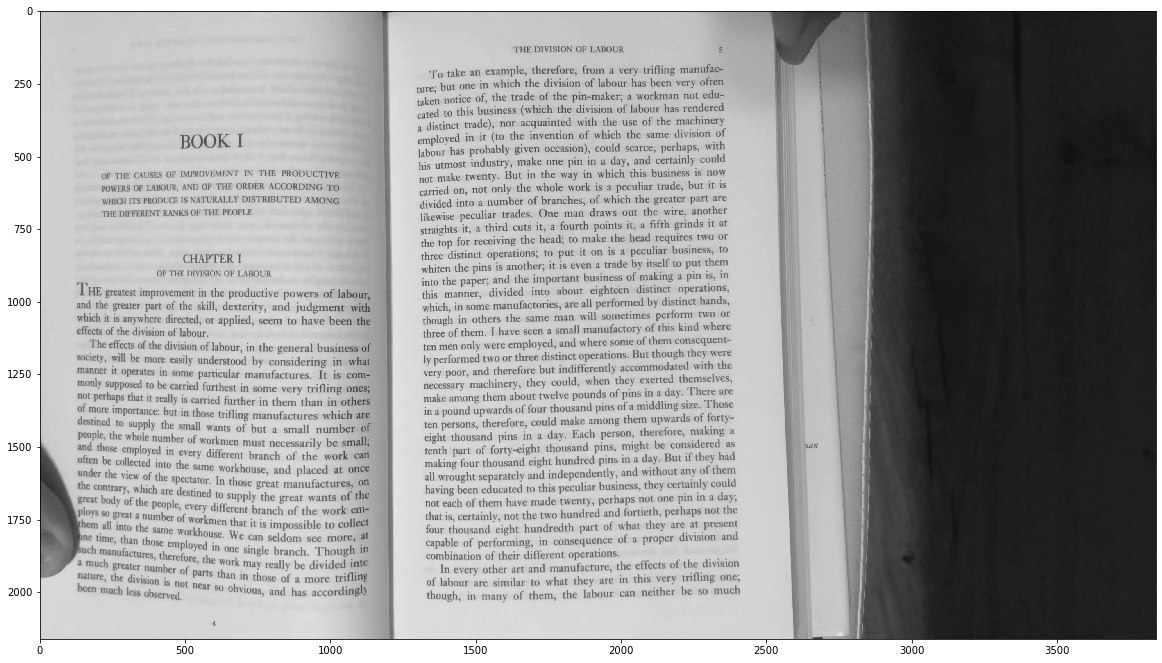

In [23]:
utils.draw_frame(image)

In [24]:
for section in sorted(grouped_lines):
    lines=grouped_lines[section]
    print("\n".join([l.text for l in lines]))
    print("---------")

BOOK I
OF THE CAUSES OF IMPROVEMENT IN THE PRODUCTIVE
POWERS OF LABOUR, AND OF THE ORDER ACCORDING TO
WHICH ITS PRODUCE IS NATURALLY DISTRIBUTED AMONG
THE DIFFERENT RANKS OF THE PEOPLE
CHAPTER I
OF THE DIVISION OF LABOUR
THE greatest improvement in the productive powers of labour,
and which the greater part of the skill, dexterity, and judgment with
effects it of is the anywhere division directed, of labour. or applied, seem to have been the
The effects will of the division of labour, in the general business of
manner society, it be more easily understood by considering in what
monly operates in some particular manufactures. It is com-
not perhaps supposed to be carried furthest in some very trifling
of that it really is carried ones;
more importance: to supply but in those trifling further manufactures in them than which in others are
people, the the small wants of but a small number
destined
whole number of workmen of
under often and those be the collected employed into in the every 

# That's not great...
Sorting looks right but things are looking scrambled, let's give Microsoft Read a whirl. [READ API Setup](https://docs.microsoft.com/en-us/azure/cognitive-services/computer-vision/vision-api-how-to-topics/call-read-api)

In [46]:
image=gray_images[0]

image_bytes=cv2.imencode(".png", image)[1]
bytes_io=io.BytesIO(image_bytes)
bytes_io

In [47]:
submit_response=microsoft_client.read_in_stream(
    bytes_io,
    language="en",
    reading_order="natural",
    raw=True
)
submit_response

In [48]:
import requests
from time import sleep
response=requests.get(submit_response.headers.get('Operation-Location'), headers=microsoft_client.config.credentials.in_headers)
while response.json()['status']=="running":
    sleep(3)
    response=requests.get(submit_response.headers.get('Operation-Location'), headers=microsoft_client.config.credentials.in_headers)
    response

In [49]:
response.json()

{'status': 'succeeded',
 'createdDateTime': '2022-01-06T01:39:19Z',
 'lastUpdatedDateTime': '2022-01-06T01:39:22Z',
 'analyzeResult': {'version': '3.2.0',
  'modelVersion': '2021-04-12',
  'readResults': [{'page': 1,
    'angle': -0.9141,
    'width': 3840,
    'height': 2160,
    'unit': 'pixel',
    'language': 'en',
    'lines': [{'boundingBox': [476, 419, 703, 416, 704, 475, 476, 478],
      'text': 'BOOK I',
      'appearance': {'style': {'name': 'other', 'confidence': 0.878}},
      'words': [{'boundingBox': [477, 420, 636, 417, 637, 478, 476, 478],
        'text': 'BOOK',
        'confidence': 0.994},
       {'boundingBox': [668, 417, 702, 416, 702, 477, 669, 477],
        'text': 'I',
        'confidence': 0.994}]},
     {'boundingBox': [209, 549, 1035, 545, 1035, 576, 209, 583],
      'text': 'OF THE CAUSES OF IMPROVEMENT IN THE PRODUCTIVE',
      'appearance': {'style': {'name': 'other', 'confidence': 0.878}},
      'words': [{'boundingBox': [209, 556, 242, 555, 243, 582, 210

In [50]:
read_results=response.json()['analyzeResult']['readResults']
for page in read_results:
    for line in page['lines']:
        print(line['text'])

BOOK I
OF THE CAUSES OF IMPROVEMENT IN THE PRODUCTIVE
POWERS OF LABOUR, AND OF THE ORDER ACCORDING TO
WHICH ITS PRODUCE IS NATURALLY DISTRIBUTED AMONG
THE DIFFERENT RANKS OF THE PEOPLE
CHAPTER I
OF THE DIVISION OF LABOUR
THE greatest improvement in the productive powers of labour,
and the greater part of the skill, dexterity, and judgment with
which it is anywhere directed, or applied, seem to have been the
effects of the division of labour.
The effects of the division of labour, in the general business of
society, will be more easily understood by considering in what
manner it operates in some particular manufactures. It is com-
monly supposed to be carried furthest in some very trifling ones;
not perhaps that it really is carried further in them than in others
of more importance: but in those trifling manufactures which are
destined to supply the small wants of but a small number of
people, the whole number of workmen must necessarily be small;
and those employed in every different b

# Thoughts on the Results
WOW. This is so much better than AWS. Free and does reading order!  
  
Why did I make you deal with all of this and make you do AWS?   
  
I want these tutorials to reflect the actual coding process. You may need to try multiple things quickly before deciding on something. Oftentimes your ideas won't work. Setting up AWS is a valuable skill

In [51]:
#Lets make the read api into a function. We'll call this in the next notebook where we score the text against Gutenberg
import requests
from time import sleep

def get_lines(cv2_image):
    image_bytes=cv2.imencode(".png", cv2_image)[1]
    bytes_io=io.BytesIO(image_bytes)
    
    #https://docs.microsoft.com/en-us/azure/cognitive-services/computer-vision/vision-api-how-to-topics/call-read-api
    submit_response=microsoft_client.read_in_stream(
        bytes_io,
        language="en",
        reading_order="natural",
        raw=True
    )
    sleep(5)#Really we should "poll" submit response periodically but this should be fine for now
    
    #based on https://stackoverflow.com/questions/66322410/azure-computer-vision-sdk-read-in-stream-always-returns-bad-request
    response=requests.get(submit_response.headers.get('Operation-Location'), 
                          headers=microsoft_client.config.credentials.in_headers#the python sdk is a little limited or poorly documented
                         )
    read_results=response.json()['analyzeResult']['readResults']
    if len(read_results)>1:
        raise Exception("multiple pages returned somehow!")
    else:
        lines=[line['text'] for line in read_results[0]['lines']]
        return lines


In [52]:
import tqdm
page_lines=[]
for image in tqdm.tqdm(gray_images):
    page_lines.append(get_lines(image))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:25<00:00,  8.52s/it]


In [53]:
page_lines

[['BOOK I',
  'OF THE CAUSES OF IMPROVEMENT IN THE PRODUCTIVE',
  'POWERS OF LABOUR, AND OF THE ORDER ACCORDING TO',
  'WHICH ITS PRODUCE IS NATURALLY DISTRIBUTED AMONG',
  'THE DIFFERENT RANKS OF THE PEOPLE',
  'CHAPTER I',
  'OF THE DIVISION OF LABOUR',
  'THE greatest improvement in the productive powers of labour,',
  'and the greater part of the skill, dexterity, and judgment with',
  'which it is anywhere directed, or applied, seem to have been the',
  'effects of the division of labour.',
  'The effects of the division of labour, in the general business of',
  'society, will be more easily understood by considering in what',
  'manner it operates in some particular manufactures. It is com-',
  'monly supposed to be carried furthest in some very trifling ones;',
  'not perhaps that it really is carried further in them than in others',
  'of more importance: but in those trifling manufactures which are',
  'destined to supply the small wants of but a small number of',
  'people, t

In [47]:
for i,lines in enumerate(page_lines):
    with open(f"pages/{i}.txt", "w+") as f:
        f.write("\n".join(lines))